##### Exercício 5
Utilize a rede neural perceptron de múltiplas camadas para fazer a predição de um passo,
até predição de três passos, da série temporal:<br>
x(n) = sen(n + sen²(n))<br>
mostrando para cada caso os erros de predição.<br>


## Geração de dados

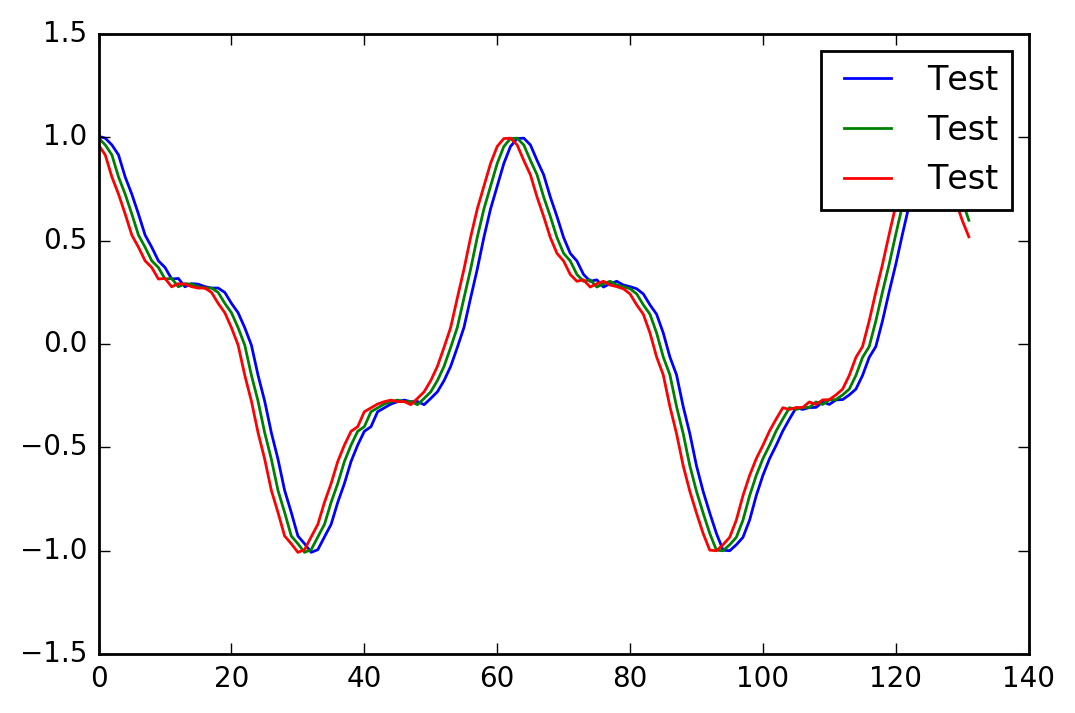

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

function_to_learn = lambda x: np.sin(x + np.sin(x)**2) + 0.01*np.random.randn(*x.shape)
all_X = np.arange(0, 40, 0.1, 'float')
all_X = [function_to_learn(x) for x in all_X]
all_data_X = np.zeros(shape=(int(len(all_X)-9), 10))
i = 0
for index, elem in enumerate(all_X):
    row_X = all_X[index:10+index]
    if len(row_X) == 10:
        all_data_X[i] = row_X
        i = i + 1

test_X = all_data_X.copy()
test_X = test_X[250:]
test_y = [[x[1], x[2], x[3]] for x in test_X]
test_y = test_y[9:]
test_X = test_X[:-9]

all_X = np.arange(0, 20, 0.1, 'float')
all_X = [function_to_learn(x) for x in all_X]
all_data_X = np.zeros(shape=(int(len(all_X)-9), 10))
i = 0
for index, elem in enumerate(all_X):
    row_X = all_X[index:10+index]
    if len(row_X) == 10:
        all_data_X[i] = row_X
        i = i + 1

all_data_y = [[x[1], x[2], x[3]] for x in all_data_X]
all_data_y = all_data_y[9:]
all_data_X = all_data_X[:-9]

all_data_X, all_data_y = shuffle(all_data_X, all_data_y, random_state=0)

train_size = int(len(all_data_X)*0.75)
train_X = all_data_X[:train_size]
train_y = all_data_y[:train_size]
val_X = all_data_X[train_size:]
val_y = all_data_y[train_size:]

plt.plot(test_y, label='Test')
plt.legend()
_ = plt.ylim()

### Demonstração da geração de dados

In [2]:
print('{0} => {1}'.format(train_X[0], train_y[0]))
print('{0} => {1}'.format(train_X[1], train_y[1]))
print('{0} => {1}'.format(train_X[2], train_y[2]))
print('{0} => {1}'.format(train_X[3], train_y[3]))

[ 0.01111275 -0.07710282 -0.19363707 -0.33627671 -0.49881801 -0.61653213
 -0.77074008 -0.86757903 -0.95982164 -0.99088084] => [-0.9930719163528666, -0.9590673506286821, -0.8939317281480306]
[0.38494227 0.34591858 0.30211376 0.28462049 0.26509023 0.27941645
 0.26864105 0.28015425 0.28453436 0.25661071] => [0.22574530241380053, 0.20644479729368165, 0.12859590370939458]
[-0.1762481  -0.32066877 -0.45910399 -0.60632678 -0.74417057 -0.8569331
 -0.95744493 -0.97459217 -1.00257969 -0.97029988] => [-0.9120633974645597, -0.8266696345280129, -0.7149520839645905]
[-0.49881801 -0.61653213 -0.77074008 -0.86757903 -0.95982164 -0.99088084
 -0.99307192 -0.95906735 -0.89393173 -0.77822271] => [-0.7043152505952084, -0.6450692326615641, -0.5331650729783013]


## Rede Neural

In [3]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)

tf.reset_default_graph()

learning_rate = 0.001
epoch = 1000
interval = 25
batch_size = 1
n_batches = train_X.shape[0]//batch_size

# Layer's sizes
x_size = 10   # Number of input node
h_size = 10   # Number of hidden nodes
y_size = 3   # Number of outcomes

# Symbols
X = tf.placeholder(tf.float32, shape=[None, x_size], name='X')
y = tf.placeholder(tf.float32, shape=[None, y_size], name='y')

# Weight initializations
w1 = tf.Variable(tf.random_normal(shape=(x_size, h_size)))
b1 = tf.Variable(tf.random_normal(shape=[h_size]))
w2 = tf.Variable(tf.random_normal(shape=(h_size, y_size)))
b2 = tf.Variable(tf.random_normal(shape=[y_size]))

# Operations
hidden_output = tf.nn.tanh(tf.add(tf.matmul(X, w1), b1))
final_output = tf.nn.tanh(tf.add(tf.matmul(hidden_output, w2), b2), name='final_output')

# Cost Function
loss = tf.reduce_mean(tf.square(final_output - y))
#loss = tf.nn.l2_loss(final_output - y)
# Optimizer
# GD
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer().minimize(loss)

# Momentum GD
#optimizer = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(loss)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Run SGD
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Training
print('Training the model...')
losses = {'train':[], 'validation':[]}

for e in range(epoch):
    #shuffled ordering
    random_X, random_y = shuffle(train_X, train_y, random_state=0)
    for i in range(n_batches):
        batch_X = random_X[i * batch_size:(i+1) * batch_size]
        batch_y = random_y[i * batch_size:(i+1) * batch_size]
        sess.run(optimizer,feed_dict = {X: batch_X, y:batch_y})
    if e % interval == 0:
        train_loss = sess.run(loss, feed_dict={X: train_X, y: train_y})
        val_loss   = sess.run(loss, feed_dict={X: val_X, y: val_y})
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        print('Epoch', e, '|',
              'Batch', i, '|',
              'Train Loss:', train_loss , '|',
              'Validation Loss:', val_loss)

save_path = saver.save(sess, './model/my_test_model5',global_step=1000)
print("Model saved in path: %s" % save_path)
sess.close()

Training the model...
Epoch 0 | Batch 135 | Train Loss: 0.86529195 | Validation Loss: 0.8535414
Epoch 25 | Batch 135 | Train Loss: 0.45105496 | Validation Loss: 0.35438153
Epoch 50 | Batch 135 | Train Loss: 0.44258177 | Validation Loss: 0.34774816
Epoch 75 | Batch 135 | Train Loss: 0.09874564 | Validation Loss: 0.07331918
Epoch 100 | Batch 135 | Train Loss: 0.0040820776 | Validation Loss: 0.0054362095
Epoch 125 | Batch 135 | Train Loss: 0.0020723247 | Validation Loss: 0.0027074802
Epoch 150 | Batch 135 | Train Loss: 0.0012738579 | Validation Loss: 0.0015143595
Epoch 175 | Batch 135 | Train Loss: 0.0010152282 | Validation Loss: 0.0012112341
Epoch 200 | Batch 135 | Train Loss: 0.0009179697 | Validation Loss: 0.0011151735
Epoch 225 | Batch 135 | Train Loss: 0.000862095 | Validation Loss: 0.0010561146
Epoch 250 | Batch 135 | Train Loss: 0.0008228275 | Validation Loss: 0.001009225
Epoch 275 | Batch 135 | Train Loss: 0.0007932009 | Validation Loss: 0.00097122
Epoch 300 | Batch 135 | Train Lo

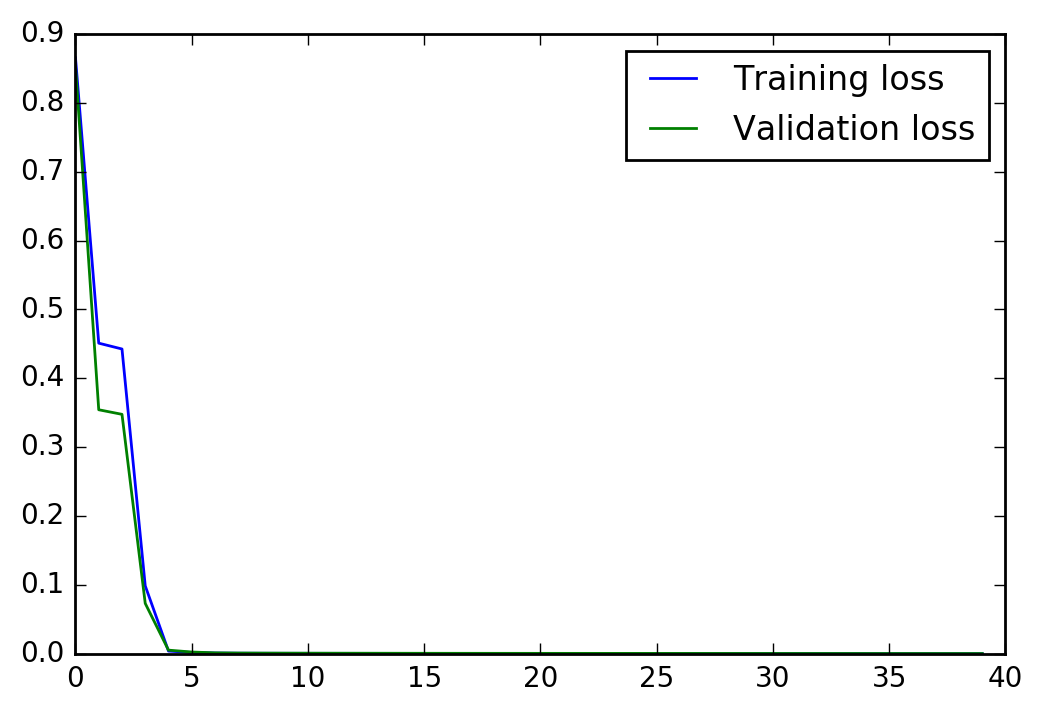

In [4]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Testando a Rede

INFO:tensorflow:Restoring parameters from ./model/my_test_model5-1000


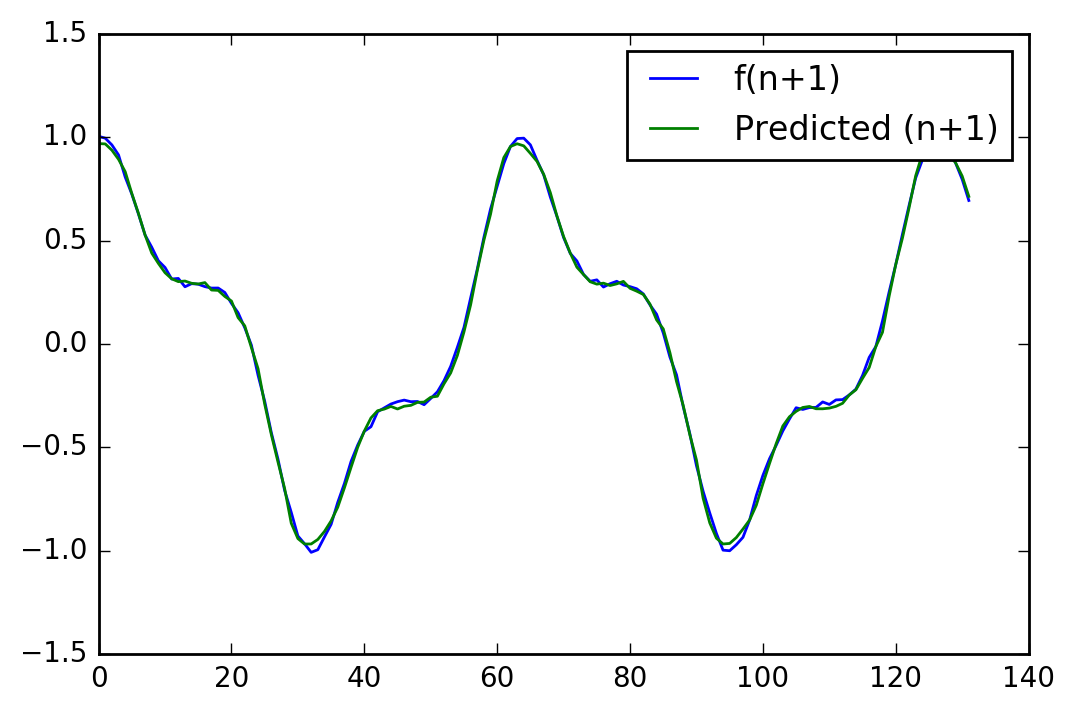

In [5]:
# Import model
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./model/my_test_model5-1000.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./model'))
    
    graph = tf.get_default_graph()
    X = graph.get_tensor_by_name("X:0")
    final_output = graph.get_tensor_by_name("final_output:0")
    
    results = {'actual':[], 'predicted':[]}
    for i in range(len(test_X)):
        predicted = sess.run(final_output, feed_dict={X: [test_X[i]]})
        results['actual'].append(test_y[i][0])
        results['predicted'].append(predicted[0][0])

plt.plot(results['actual'], label='f(n+1)')
plt.plot(results['predicted'], label='Predicted (n+1)')
plt.legend()
_ = plt.ylim()

INFO:tensorflow:Restoring parameters from ./model/my_test_model5-1000


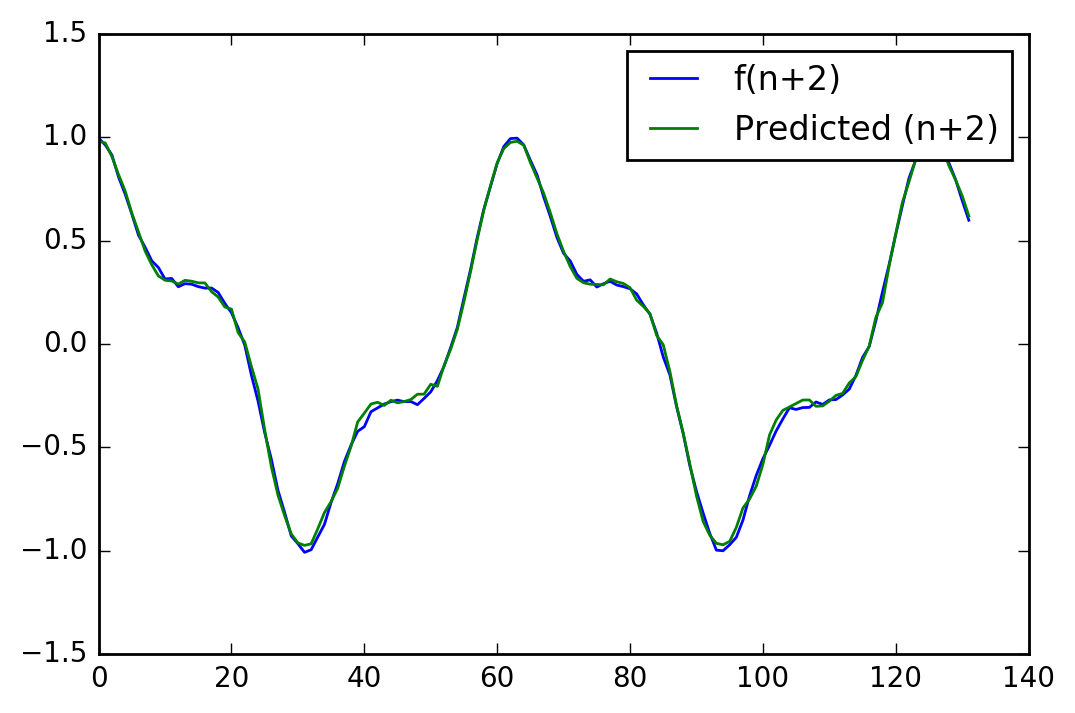

In [6]:
# Import model
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./model/my_test_model5-1000.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./model'))
    
    graph = tf.get_default_graph()
    X = graph.get_tensor_by_name("X:0")
    final_output = graph.get_tensor_by_name("final_output:0")
    
    results = {'actual':[], 'predicted':[]}
    for i in range(len(test_X)):
        predicted = sess.run(final_output, feed_dict={X: [test_X[i]]})
        results['actual'].append(test_y[i][1])
        results['predicted'].append(predicted[0][1])

plt.plot(results['actual'], label='f(n+2)')
plt.plot(results['predicted'], label='Predicted (n+2)')
plt.legend()
_ = plt.ylim()

INFO:tensorflow:Restoring parameters from ./model/my_test_model5-1000


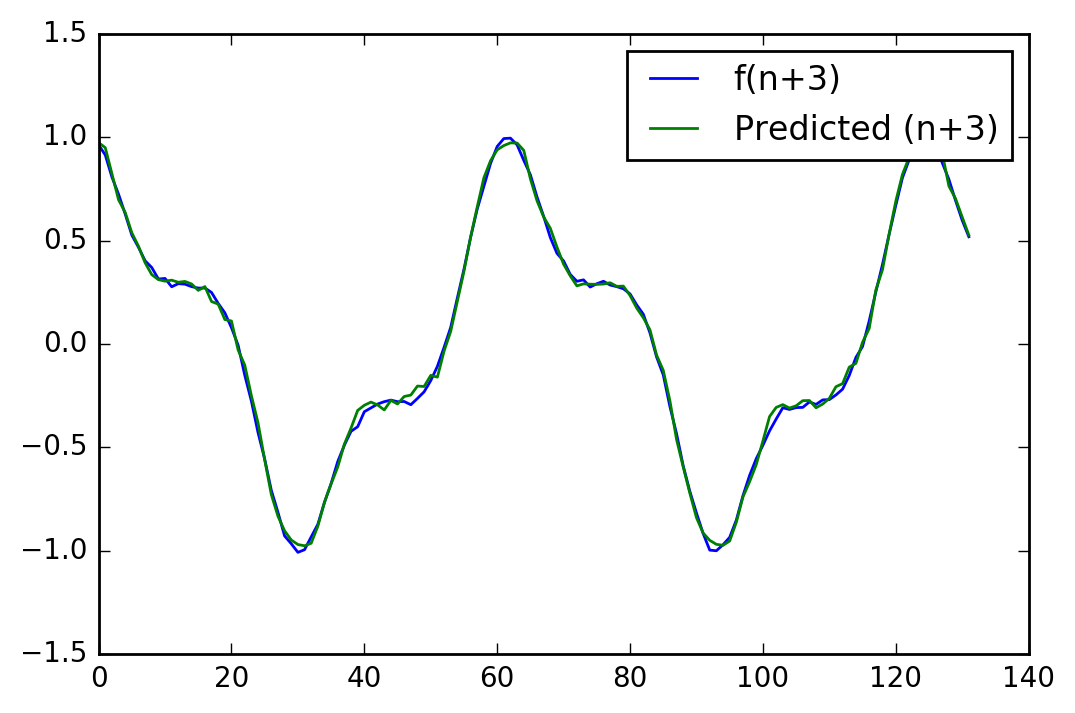

In [7]:
# Import model
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('./model/my_test_model5-1000.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./model'))
    
    graph = tf.get_default_graph()
    X = graph.get_tensor_by_name("X:0")
    final_output = graph.get_tensor_by_name("final_output:0")
    
    results = {'actual':[], 'predicted':[]}
    for i in range(len(test_X)):
        predicted = sess.run(final_output, feed_dict={X: [test_X[i]]})
        results['actual'].append(test_y[i][2])
        results['predicted'].append(predicted[0][2])

plt.plot(results['actual'], label='f(n+3)')
plt.plot(results['predicted'], label='Predicted (n+3)')
plt.legend()
_ = plt.ylim()